In [1]:
canvas_config = {
    'start_x' :30,
    'start_y' : 750,
    'token_spacing' : 100,
    'line_spacing' : 8,
  'count' : 0,
  'key_spacing' : 200,
  'header_spacing' : 15,
  'section_spacing' : 50,
  'line_break' : 20
}

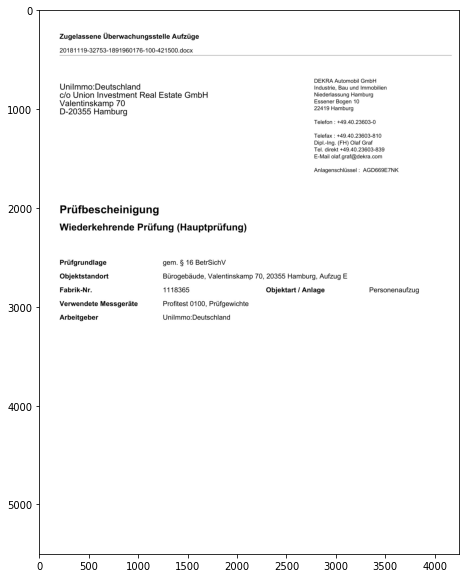

In [1]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen.canvas import Canvas as Canvas
import cv2
import matplotlib.pyplot as plt 
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
from PIL import Image
from pdf2image import convert_from_path
from reportlab.lib.colors import HexColor
from reportlab.lib import colors
import os
from reportlab.lib.utils import ImageReader
from reportlab.lib.units import inch
import numpy as np
from reportlab.lib.pagesizes import A4
import random

# register the TTF font file
pdfmetrics.registerFont(TTFont('Arial', 'arial.ttf'))
pdfmetrics.registerFont(TTFont('Arial-Bold', 'arialbd.ttf'))

header = 'Zugelassene Überwachungsstelle Aufzüge'
file_name = '20181119-32753-1891960176-100-421500.docx'
page_no = 'Seite 1 von 1'

client_address = {
  'line1' : 'UniImmo:Deutschland',
  'line2' : 'c/o Union Investment Real Estate GmbH',
  'line3' : 'Valentinskamp 70',
  'line4' : 'D-20355 Hamburg'
}

client_address_config ={
  'font' : 'Arial',
  'line_break' : 12,
  'font_size' : 12
}

evaluator_address = {
  'address' :{
    'line1' : 'DEKRA Automobil GmbH',
    'line2' : 'Industrie, Bau und Immobilien',
    'line3' : 'Niederlassung Hamburg',
    'line4' : 'Essener Bogen 10',
    'line5' : '22419 Hamburg'
    },
  'Telefon' : '+49.40.23603-0',
  'Telefax' : '+49.40.23603-810',
  'Kontakt' : {
    'line1' : 'Dipl.-Ing. (FH) Olaf Graf',
    'line2' :'Tel. direkt +49.40.23603-839',
    'line3' : 'E-Mail olaf.graf@dekra.com',
  },
  
  'Anlagenschlüssel' : ' AGD669E7NK'
}

evaluator_address_config = {
  'font':'Arial',
  'line_break' : 10,
  'font_size' : 8,
  'new_line':['Telefax', 'kontakt']
}

test_certificate = {
  'Prüfbescheinigung' : 'Wiederkehrende Prüfung (Hauptprüfung)'
}

test_certificate_config = {
  'font_size' : 16,
  'font_type': 'Arial-Bold',
  'line-break' : 25 # should be 25-30
}

test_certificate_results = {
  'Prüfgrundlage' : 'gem. § 16 BetrSichV', #Str some code related to legal documents
  'Objektstandort' : 'Bürogebäude, Valentinskamp 70, 20355 Hamburg, Aufzug E', #str address
  'Objektart / Anlage' : 'Personenaufzug', #Str type of elevator
  'Fabrik-Nr.' : '1118365', #long 6-9 digits
  'Arbeitgeber' : client_address['line1'],
  'Eigennummer' : 'HC-ID 13011', # str(2)-str(2) 5 digit number,
  'Eigenname' : 'WE 1172',
  'Verwendete Messgeräte' : 'Profitest 0100, Prüfgewichte', ## Not clear str followed by some 4 digit num and then str 
}

test_certificate_results_config = {
  'font_size' : 10,
  'font-type-keys' : 'Arial-Bold',
  'font-type-vals' : 'Arial',
  'vertical-left-only' : ['Objektstandort', 'Arbeitgeber'],
  'line-break' : 20,
  'key-val-spacing': 150
  
}

def next_line(start_y, line_break):
  return start_y - line_break

def rearange_key_vals_test_results(dict_list, keys_to_keep, indices): ## keys which needs to appear either of the positions mentioned in indices usually 1,6
  for i , (key, val) in enumerate(dict_list):
    if key in keys_to_keep and i not in indices:
      swap_index = random.choice(indices) if len(indices) > 1 else indices[0] 
      dict_list[i], dict_list[swap_index] = dict_list[swap_index], dict_list[i]
      if len(indices)> 1 :
        indices.pop(indices.index(swap_index))
    
  return dict_list

def draw_client_address(client_address, canvas, x, y):
  canvas.setFont(client_address_config['font'], client_address_config['font_size'])
  keys_sorted = [key for key in client_address.keys()]
  
  for key in keys_sorted:
    canvas.drawString(x, y, client_address[key])
    y = next_line(y, client_address_config['line_break'])
  return x, y

def draw_evaluator_address(evaluator_address, evaluator_address_config, canvas, x, y, y_temp):
  canvas.setFont(evaluator_address_config['font'], evaluator_address_config['font_size'])
  start_x_temp = random.choice(np.arange(400,430, 10))
  y = y_temp
  count = 0
  for key in evaluator_address.keys():
    if not type(evaluator_address[key]) == dict: 
      canvas.drawString(start_x_temp, y, key + ' : ' + evaluator_address[key])
      count += 1
      y = next_line(y, evaluator_address_config['line_break'])
    else:
      for k in evaluator_address[key].keys():
        canvas.drawString(start_x_temp, y, evaluator_address[key][k])
        count += 1
        y = next_line(y, evaluator_address_config['line_break'])
    if count%5==0 or count%3==0: # Adding random new lines
      y = next_line(y, evaluator_address_config['line_break'])
  return x, y

def draw_test_certificate_results(test_certificate_results, test_certificate_results_config, canvas, x, y):
  items_test_certificate_results = list(test_certificate_results.items())
  random.shuffle(items_test_certificate_results)
  items_test_certificate_results = rearange_key_vals_test_results(items_test_certificate_results, test_certificate_results_config['vertical-left-only'], [1,6])
  start_x_temp = x
  new_lines = []
  for i , (key, val) in enumerate(items_test_certificate_results):
    if i in (5,6) and key not in test_certificate_results_config['vertical-left-only']:
      start_x_temp = start_x_temp + 2* test_certificate_results_config['key-val-spacing']
      y = new_lines[-3]
    canvas.setFont(test_certificate_results_config['font-type-keys'], test_certificate_results_config['font_size'])
    canvas.drawString(start_x_temp, y , key)
    #start_x_temp = start_x_temp + test_certificate_results_config['key-val-spacing']
    canvas.setFont(test_certificate_results_config['font-type-vals'], test_certificate_results_config['font_size'])
    canvas.drawString(start_x_temp + test_certificate_results_config['key-val-spacing'], y, val)
    new_lines.append(y)
    y = next_line(y, test_certificate_results_config['line-break'])
  
  return x, y 
  
def draw_report(header:dict=None, report_name:str='form.pdf', image_path:str = None):
  
  start_x = 30
  start_x_temp = start_x
  start_y = 750
  start_y_temp = start_y
  token_spacing = 100
  line_spacing = 8
  count = 0
  key_spacing = 200
  header_spacing = 15
  section_spacing = 50
  line_break = 20

  
  c = Canvas(report_name)
  canvas = c
  canvas.setPageSize(letter)
  canvas.setLineWidth(.3)
  canvas.setFont('Arial-Bold', 10) 
  
  canvas.setFillColor(HexColor(0x000000))
  canvas.drawString(start_x,start_y, header) # start_x = 30, start_y = 750, font_size = 10  
  canvas.setFont('Arial', 9)
  
  new_line = next_line(start_y, line_break)
  
  canvas.drawString(start_x,new_line, file_name)
  
  new_line = next_line(new_line, 4)
  canvas.line(start_x, new_line, 600, new_line)
  
  ## Section Spacing
  new_line = next_line(new_line, section_spacing)
  
  ## Used for evaluator address
  new_line_temp = new_line + 10
  
  # Section 1
  ## Client Address
  
  _, new_line = draw_client_address(client_address, canvas, start_x, new_line)

  #canvas.line(480,747,580,747)
  
  #Section 2
  _, new_line = draw_evaluator_address(evaluator_address, evaluator_address_config, canvas, start_x, new_line, new_line_temp)  
  
  ## Section 3 test_certificate
  new_line = next_line(new_line, section_spacing)
  canvas.setFont(test_certificate_config['font_type'], test_certificate_config['font_size'])
  canvas.drawString(start_x, new_line, list(test_certificate.keys())[0])
  new_line = next_line(new_line, test_certificate_config['line-break'])
  canvas.setFont(test_certificate_config['font_type'], test_certificate_config['font_size'] - 2)
  canvas.drawString(start_x, new_line, test_certificate['Prüfbescheinigung'])
  
  ## Section 4 test_certificate_results
  new_line = next_line(new_line, section_spacing)
  
  _, new_line = draw_test_certificate_results(test_certificate_results, test_certificate_results_config, canvas, start_x, new_line)
  '''items_test_certificate_results = list(test_certificate_results.items())
  random.shuffle(items_test_certificate_results)
  items_test_certificate_results = rearange_key_vals_test_results(items_test_certificate_results, test_certificate_results_config['vertical-left-only'], [1,6])
  
  
  start_x_temp = start_x
  new_lines = []
  for i , (key, val) in enumerate(items_test_certificate_results):
    if i in (5,6) and key not in test_certificate_results_config['vertical-left-only']:
      start_x_temp = start_x_temp + 2* test_certificate_results_config['key-val-spacing']
      new_line = new_lines[-3]
    canvas.setFont(test_certificate_results_config['font-type-keys'], test_certificate_results_config['font_size'])
    canvas.drawString(start_x_temp, new_line , key)
    #start_x_temp = start_x_temp + test_certificate_results_config['key-val-spacing']
    canvas.setFont(test_certificate_results_config['font-type-vals'], test_certificate_results_config['font_size'])
    canvas.drawString(start_x_temp + test_certificate_results_config['key-val-spacing'], new_line, val)
    new_lines.append(new_line)
    new_line = next_line(new_line, test_certificate_results_config['line-break'])'''
    
      #new_line = new_line - 2* test_certificate_results_config['line-break']

  canvas.save()
  
draw_report(header=header, report_name='form.pdf')
pages = convert_from_path('form.pdf', 500)
pages[0].save(f'form.jpg', 'JPEG')
plt.figure(figsize = (200,10))
plt.imshow(cv2.imread('form.jpg')[:,:,::-1])

In [1]:


#draw_report(header=header, report_name='form.pdf')

#template1.draw_report(header=header, report_name='form.pdf')
#pages = convert_from_path('form1.pdf', 500)
#pages[0].save(f'form1.jpg', 'JPEG')
#plt.figure(figsize = (200,10))
#plt.imshow(cv2.imread('form.jpg')[:,:,::-1])

c:\Users\abhij\anaconda3\envs\ml_22\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
from template1 import Template_Dekra

from reportlab.lib.pagesizes import letter
from reportlab.pdfgen.canvas import Canvas as Canvas
import cv2
import matplotlib.pyplot as plt 
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
from PIL import Image
from pdf2image import convert_from_path
from reportlab.lib.colors import HexColor
from reportlab.lib import colors
import os
from reportlab.lib.utils import ImageReader
from reportlab.lib.units import inch
import numpy as np
from reportlab.lib.pagesizes import A4
import random
from transformers import LayoutLMv2ForRelationExtraction, AutoTokenizer
from template1 import global_keys
start_x = 30
start_x_temp = start_x
start_y = 750
start_y_temp = start_y
token_spacing = 100
line_spacing = 8
count = 0
key_spacing = 200
header_spacing = 15
section_spacing = 30
line_break = 20

    #file_name='form.pdf'
header = 'Zugelassene Überwachungsstelle Aufzüge'
file_name = '20181119-32753-1891960176-100-421500.docx'
report_name = 'form2.pdf'
page_no = 'Seite 1 von 1'

template1 = Template_Dekra(start_x = start_x,
        start_y = start_y,
        token_spacing = token_spacing,
        line_spacing = line_spacing,
        key_spacing = key_spacing,
        header_spacing = header_spacing,
        section_spacing = section_spacing,
        line_break = line_break,
        header = header,
        file_name = file_name,
        report_name=report_name,
        page_no = page_no)
#draw_report(header=header, report_name='form.pdf')

template1.draw_report(header=header, report_name='form2.pdf')
#pages = convert_from_path('form.pdf', 500)
#pages[0].save(f'form.jpg', 'JPEG')
model = LayoutLMv2ForRelationExtraction.from_pretrained("microsoft/layoutxlm-base")
tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutxlm-base")
#print(f'len(tokenizer) {len(tokenizer)}')
tokens, bboxes, image = template1.get_ocr_data(image_path='form2.jpg')
print(len(tokens))
#print([token for token in tokens if token in set(string.punctuation) and token in (' ', '')])
#print('------------------------')
#template1.add_tokens(tokens=tokens)
#tokens = [token.lower() for token in tokens if token != ' ']
tokens, bboxes = template1.preprocess_tokens(tokens=tokens, bboxes=bboxes)
print(len(tokens))
#tokens = np.load('tokens_temp.npy')
#bboxes = np.load('bboxes_temp.npy')
#print(f'len(tokens) {len(tokens)}')
#print(f'len(bboxes) {len(bboxes)}')
#plt.figure(figsize=(20,10))
#plt.imshow(image)
#tokenizer, model = template1.add_tokens_tokenizer(tokens = tokens, tokenizer = tokenizer, model = model)
input_ids, bboxes, input_id_map = template1.encode_tokens(tokens=tokens, bboxes=bboxes, tokenizer=tokenizer)
#tokens, bboxes = template1.preprocess_tokens(tokens= tokens, bboxes= bboxes)
#print(tokens)
#print(f'len of tokens {len(tokens)}')
#time.sleep(10)

#print(input_ids)
#tokenizer = AutoTokenizer.from_pretrained('layout_xlm_base_tokenizer')
#tokenizer = AutoTokenizer.from_pretrained('layout_xlm_base_tokenizer_alt')
#print(f'len(tokenizer) {len(tokenizer)}')
    
#input_ids = tokenizer.encode(text = tokens, boxes = bboxes, is_pretokenized=False)  
key_vals_unified = template1.unify_keys_vals(global_keys)
labels= template1.label_input_ids(unified_dict=key_vals_unified,tokens = tokens,  bboxes = bboxes, input_ids=input_ids, input_id_map=input_id_map, tokenizer=tokenizer)
#token_group_key, token_group_val, token_group_others = template1.form_token_groups(unified_dict=key_vals_unified, tokens=tokens, bboxes=bboxes)
key_set, val_set, token_map = template1.form_token_groups(unified_dict=key_vals_unified, tokens=tokens, bboxes=bboxes)
entities = template1.form_entities(unified_dict=key_vals_unified,tokens = tokens,  bboxes = bboxes, input_ids=input_ids, input_id_map=input_id_map, tokenizer=tokenizer)
print(len(input_ids))
print(len(labels))

Some weights of the model checkpoint at microsoft/layoutxlm-base were not used when initializing LayoutLMv2ForRelationExtraction: ['layoutlmv2.visual.backbone.bottom_up.res3.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.4.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.22.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.7.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.1.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.16.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.15.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.1.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.16.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.3.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv3.norm.num_batches_tracked', 'layout

129
117
0
tokens ['wiederkehrende', 'hauptprüfung']
token_first wiederkehrende
token_last hauptprüfung
token_first_tokenized ['wiederkehrende']
token_last_tokenized ['hauptprüfung']
token_first_tokenized [250030]
token_last_tokenized [250013]
tokenizer.decode(input_ids.index(id_list_key_last_token[-1]) + 1) da
start 44 wiederkehrende
----------------
1
tokens ['gem', '16', 'betrsichv']
token_first gem
token_last betrsichv
token_first_tokenized ['▁gem']
token_last_tokenized ['betrsichv']
token_first_tokenized [30203]
token_last_tokenized [250057]
tokenizer.decode(input_ids.index(id_list_key_last_token[-1]) + 1) ;
start 71 gem
----------------
2
tokens ['bürogebäude', 'valentinskamp', '70', 'aufzug', 'hamburg', '20355']
token_first bürogebäude
token_last 20355
token_first_tokenized ['bürogebäude']
token_last_tokenized ['20355']
token_first_tokenized [250033]
token_last_tokenized [250038]
tokenizer.decode(input_ids.index(id_list_key_last_token[-1]) + 1) و
start 61 bürogebäude
------------

In [6]:
input_id_map

{'zugelassene': 250069,
 'überwachungsstelle': 250023,
 'aufzüge': 250032,
 '20181119-32753-1891960176-100-421500.docx': 250006,
 'dekra': 250031,
 'automobil': 250055,
 'gmbh': 250049,
 'unilmmo:deutschland': 250063,
 '▁industrie': 95845,
 '▁bau': 38267,
 '▁und': 165,
 'immobilien': 250030,
 'c/o': 250005,
 '▁union': 69941,
 'investment': 250072,
 '▁real': 2773,
 '▁estate': 97761,
 'niederlassung': 250012,
 'hamburg': 250058,
 '▁70': 2358,
 'essener': 250036,
 '▁bogen': 139920,
 '▁10': 209,
 'd-20355': 250059,
 '22419': 250054,
 '▁telefon': 2924,
 '49.40.23603-0': 250017,
 'telefax': 250028,
 '49.40.23603-810': 250066,
 'dipl.-ing': 250034,
 '▁fh': 30600,
 'olaf': 250067,
 '▁graf': 26603,
 '▁tel': 8131,
 '▁direkt': 7307,
 '49.40.23603-839': 250068,
 'e-mail': 250070,
 'olaf.graf@dekra.com': 250050,
 'anlagenschlüssel': 250027,
 'agd669e7nk': 250019,
 'prüfbescheinigung': 250021,
 'wiederkehrende': 250046,
 '▁': 6,
 'prüfung': 159601,
 'hauptprüfung': 250052,
 'objektstandort': 250004,

In [3]:
print(key_set) 
print(val_set)
print(token_map)

{'prüfbescheinigung': ['prüfbescheinigung'], 'prüfgrundlage': ['prüfgrundlage'], 'objektstandort': ['objektstandort'], 'objektart / anlage': ['objektart', 'anlage'], 'fabrik-nr.': ['fabrik-nr'], 'arbeitgeber': ['arbeitgeber'], 'eigennummer': ['eigennummer'], 'eigenname': ['eigenname'], 'verwendete messgeräte': ['verwendete', 'messgeräte'], 'baujahr': ['baujahr'], 'wartungsfirma': ['wartungsfirma'], 'errichtungsgrundlage': ['errichtungsgrundlage'], 'antrieb / aufhängung': ['antrieb', 'aufhängung'], 'hersteller': ['hersteller'], 'tragfähigkeit': ['tragfähigkeit'], 'haltestellen / zugangstellen': ['haltestellen', 'zugangstellen'], 'geschwindigkeit': ['geschwindigkeit'], 'förderhöhe': ['förderhöhe']}
{'wiederkehrende prüfung (hauptprüfung)': ['wiederkehrende', 'hauptprüfung'], 'gem. § 16 betrsichv': ['gem', '16', 'betrsichv'], 'bürogebäude, valentinskamp 70, 20355 hamburg, aufzug e': ['bürogebäude', 'valentinskamp', '70', 'aufzug', 'hamburg', '20355'], 'personenaufzug': ['personenaufzug'],

In [3]:
list_str = ['e', 'objektart', 'anlage']
sorted_list = sorted(list_str, key=len, reverse=True)
sorted_list

['objektart', 'anlage', 'e']

In [4]:
print(len([key for key in key_set if len(key_set[key])!=0]))
print(len([key for key in val_set if len(val_set[key])!=0]))
print(len([token for token in token_map.keys() if 'other' in token_map[token]]))

18
16
31


In [2]:
## checking if there are ids for null chars
count = 0
for id in input_ids:
    if tokenizer.decode(id) == '':
        print(f'asd{tokenizer.decode(id)}asd')
        count += 1
count

asdasd
asdasd
asdasd
asdasd


4

In [4]:
print(len(entities['start']))
print(len(entities['end']))
print(len(entities['label']))

65
65
65


In [4]:
for i , (start, end) in enumerate(zip(entities['start'], entities['end'])):
    print(f'{i}, {tokenizer.decode(input_ids[start:end])} : {entities["label"][i]}')

0, prüfbescheinigung : 1
1, prüfgrundlage : 1
2, objektstandort : 1
3, objektart anlage : 1
4, fabrik-nr : 1
5, arbeitgeber : 1
6, eigennummer : 1
7, eigenname : 1
8, verwendetemessgeräte : 1
9, baujahr : 1
10, wartungsfirma : 1
11, errichtungsgrundlage : 1
12, antriebaufhängung : 1
13, hersteller : 1
14, tragfähigkeit : 1
15, haltestellenzugangstellen : 1
16, geschwindigkeit : 1
17, förderhöhe : 1
18, wiederkehrende prüfunghauptprüfung : 2
19, gem 16betrsichv : 2
20, bürogebäudevalentinskamp 7020355 : 2
21, personenaufzug : 2
22, 1118365 : 2
23, hc-id13011 : 2
24, we1172 : 2
25, profitest0100prüfgewichte : 2
26, 2011 : 2
27, schindleraufzüge undfahrtreppen : 2
28, en81-1 : 2
29, treibscheibe2:1 : 2
30, 1350 kgförderhöhe 18 per s : 2
31, 26 : 2
32, 4,00m/s : 2
33, 93,68 : 2
34, zugelassene : 0
35, überwachungsstelle : 0
36, 20181119-32753-1891960176-100-421500.docx : 0
37, unilmmo:deutschland : 0
38, c/o : 0
39, union : 0
40, investment : 0
41, real : 0
42, estate : 0
43, d-20355 : 0
4

In [3]:
start = entities['start'][32]
end = entities['end'][32]

print(start)
print(end)
print(f'asd{tokenizer.decode(input_ids[start])}asd')
print(f'asd {tokenizer.decode(input_ids[end])} asd')

45
87
asdasd
asd fahrtreppen asd


In [5]:
token1= "4,00"
token2= "m/s"
id1 = input_id_map[token1]
id2 = input_id_map[token2]
index1=input_ids.index(id1)
index2=input_ids.index(id2)

tokenizer.decode(input_ids[index1:index2+1])

'4,00m/s'

In [3]:
print([tokenizer.decode(id) for id in input_ids if 'uni' in tokenizer.decode(id)])
print([id for id in input_ids if 'uni' in tokenizer.decode(id)])

print([token for token in tokens if 'uni' in token])

['unilmmo:deutschland', 'union', 'unilmmo:deutschland']
[250014, 69941, 250014]
['unilmmo:deutschland', 'union', 'unilmmo:deutschland']


In [4]:
file_name = 'form.pdf'
file_name[:-4]

'form'

Confidence: 91
Text: Zugelassene

Confidence: 91
Text: Überwachungsstelle

Confidence: 96
Text: Aufzüge

Confidence: 89
Text: 20181119-32753-1891960176-100-421500.docx

Confidence: 95
Text:  

Confidence: 92
Text: DEKRA

Confidence: 96
Text: Automobil

Confidence: 96
Text: GmbH

Confidence: 91
Text: Unilmmo:Deutschland

Confidence: 96
Text: Industrie,

Confidence: 96
Text: Bau

Confidence: 95
Text: und

Confidence: 95
Text: Immobilien

Confidence: 96
Text: c/o

Confidence: 96
Text: Union

Confidence: 95
Text: Investment

Confidence: 96
Text: Real

Confidence: 95
Text: Estate

Confidence: 96
Text: GmbH

Confidence: 96
Text: Niederlassung

Confidence: 96
Text: Hamburg

Confidence: 62
Text: 70

Confidence: 96
Text: Essener

Confidence: 96
Text: Bogen

Confidence: 96
Text: 10

Confidence: 96
Text: D-20355

Confidence: 96
Text: Hamburg

Confidence: 96
Text: 22419

Confidence: 96
Text: Hamburg

Confidence: 93
Text: Telefon

Confidence: 92
Text: :

Confidence: 90
Text: +49.40.23603-0

Confide

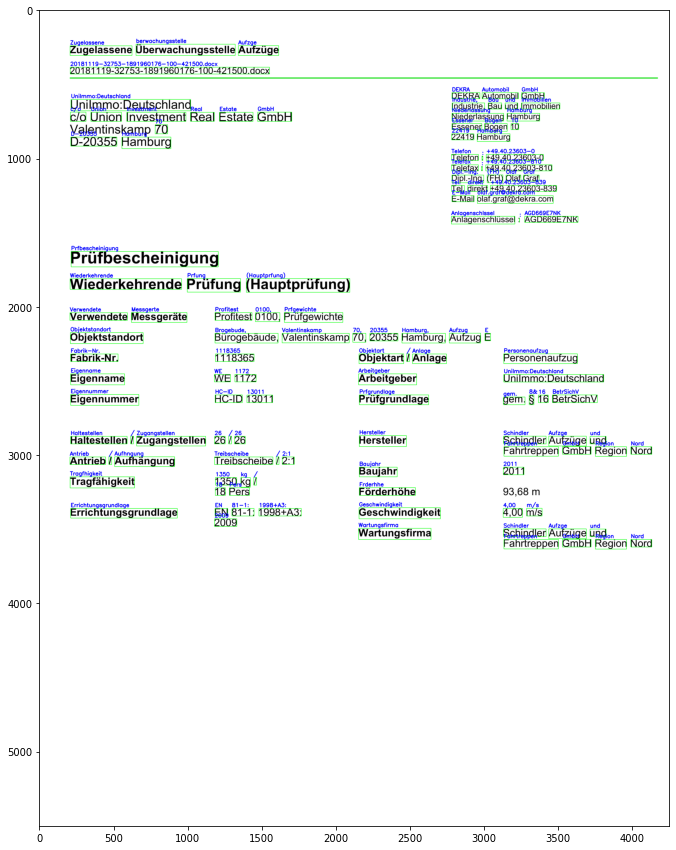

In [11]:
import pytesseract
from pytesseract import Output
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('form2.jpg')
pytesseract.pytesseract.tesseract_cmd = r'C://Program Files//Tesseract-OCR//tesseract.exe'

results = pytesseract.image_to_data(image, output_type=Output.DICT, lang='deu')
n_boxes = len(results['level'])
tokens = []
bboxes = []

#tokens = {'text' : [], 'bbox':[]}
for i in range(n_boxes):
    x = results["left"][i]
    y = results["top"][i]
    w = results["width"][i]
    h = results["height"][i]
	# extract the OCR text itself along with the confidence of the
	# text localization
    text = results["text"][i]
    
    conf = int(results["conf"][i])
    #(x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    #cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    if conf > 50:
        # display the confidence and text to our terminal
        #tokens.append((text, [x + w, y + h]))
        tokens.append(text)
        bboxes.append([x,y,x+w, y+h])
        print("Confidence: {}".format(conf))
        print("Text: {}".format(text))
        print("")
		# strip out non-ASCII text so we can draw the text on the image
		# using OpenCV, then draw a bounding box around the text along
		# with the text itself
        text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    1.2, (0, 0, 255), 3)

plt.figure(figsize = (250,15))
plt.imshow(image)
#cv2.waitKey(0)

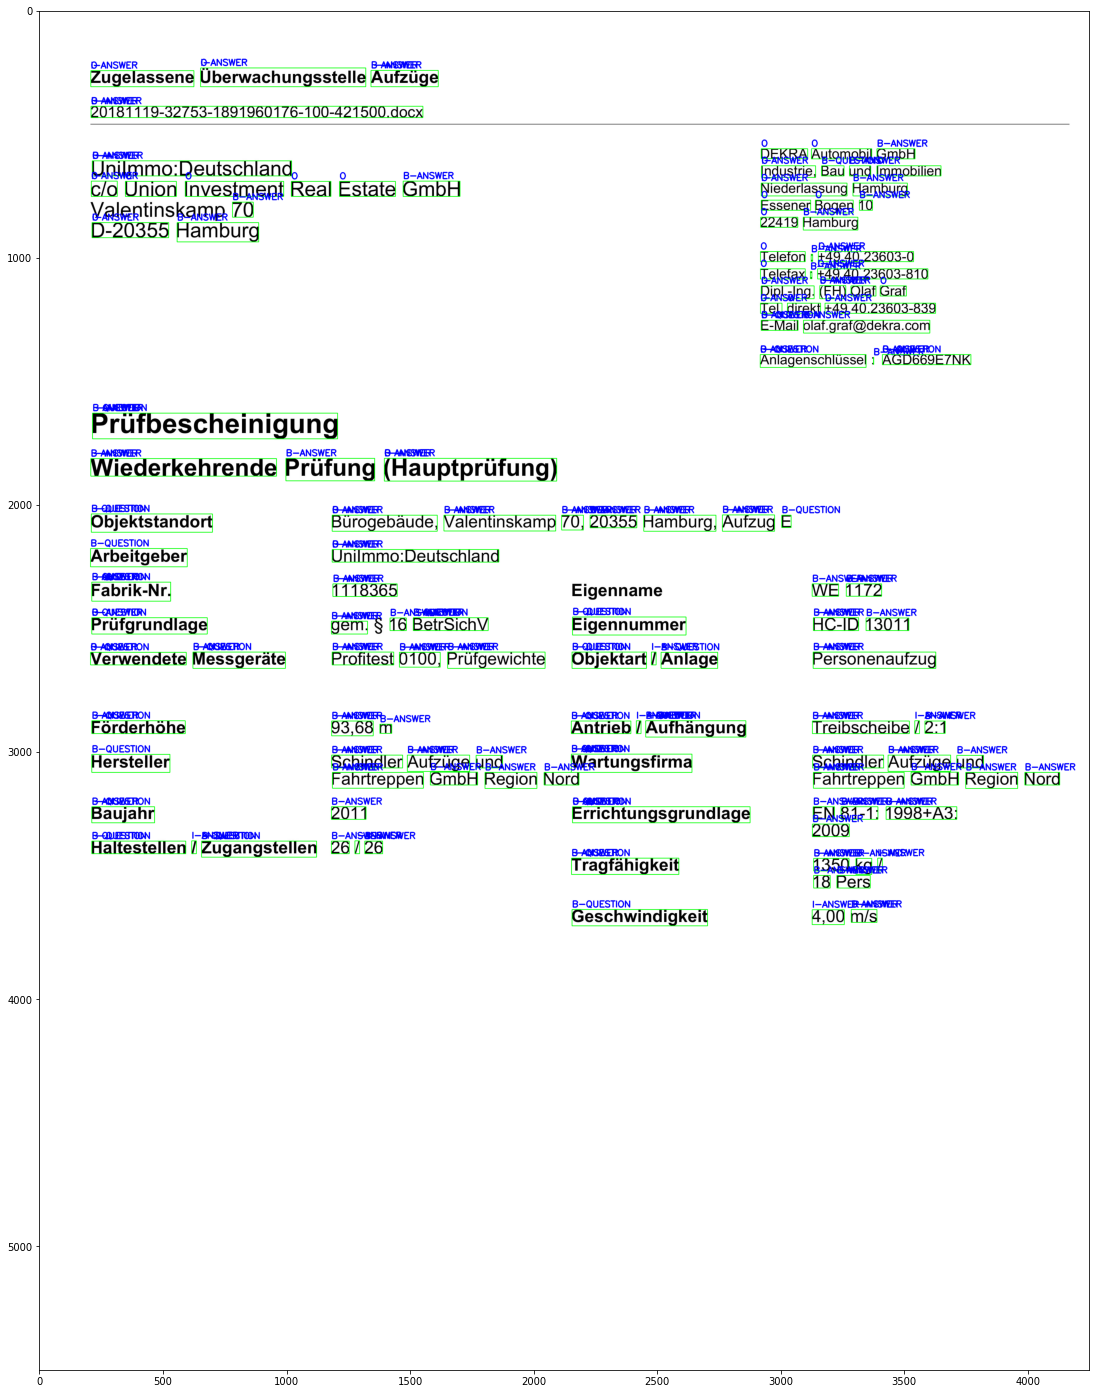

In [17]:
import pytesseract
from pytesseract import Output
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('form2.jpg')
pytesseract.pytesseract.tesseract_cmd = r'C://Program Files//Tesseract-OCR//tesseract.exe'

results = pytesseract.image_to_data(image, output_type=Output.DICT, lang='deu')
n_boxes = len(results['level'])
#tokens = []
#bboxes = []
label_vals = {'O' : 0, 'B-QUESTION' : 1, 'B-ANSWER' : 2, 'B-HEADER' : 3, 'I-ANSWER' : 4, 'I-QUESTION' : 5, 'I-HEADER' : 6}
label_vals_reversed = {0: 'O',  1: 'B-QUESTION',  2: 'B-ANSWER',  3: 'B-HEADER', 4 : 'I-ANSWER', 5 : 'I-QUESTION',  6 : 'I-HEADER'}
#tokens = {'text' : [], 'bbox':[]}
for i in range(len(bboxes)-1):
    
	# extract the OCR text itself along with the confidence of the
	# text localization
    text = label_vals_reversed[labels[i]]
    
    #conf = int(results["conf"][i])
    #(x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    #cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    #if conf > 50:
    # display the confidence and text to our terminal
    #tokens.append((text, [x + w, y + h]))
    #tokens.append(text)
    #bboxes.append([x,y,x+w, y+h])
    #print("Confidence: {}".format(conf))
    #print("Text: {}".format(text))
    #print("")
	# strip out non-ASCII text so we can draw the text on the image
	# using OpenCV, then draw a bounding box around the text along
	# with the text itself
    x1,y1,x2,y2 = bboxes[i][0], bboxes[i][1], bboxes[i][2], bboxes[i][3] 
    text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    1.2, (0, 0, 255), 3)

plt.figure(figsize = (320,25))
plt.imshow(image)
#cv2.waitKey(0)

In [6]:
#input_ids = template1.encode_new_tokens(tokens = tokens, bboxes=bboxes, tokenizer=tokenizer)
#len(input_ids)

314

In [3]:
all_input_ids =template1.encode_tokens(tokens=tokens, bboxes=bboxes, tokenizer=tokenizer)
all_input_ids

126
126


IndexError: list index out of range

In [14]:

token = tokens[0] #, tokens[1]

print(token)
#token_ids = {tokenized_token:id for token in tokens for tokenized_token in tokenizer.tokenize(token) for id in input_ids if tokenizer.decode(id)== tokenized_token}
print(tokenizer.tokenize(token))
tokenized_token = tokenizer.tokenize(token)
input_ids = tokenizer.encode(text = tokenized_token, boxes = [bboxes[0] for i in range(len(tokenized_token))], is_pretokenized=True, add_special_tokens=False)
print(input_ids)
print(tokenizer.decode(input_ids[0:91151]))

Zugelassene
['▁Zu', 'gelassen', 'e']
[6900, 6, 130023, 28]
Zu gelassen e


## Test labels 

In [15]:
id2label = {0: 'O', 1: 'B-QUESTION', 2: 'B-ANSWER', 3: 'B-HEADER', 4: 'I-ANSWER', 5: 'I-QUESTION', 6: 'I-HEADER'}
token = tokens[0] 
bboxe = bboxes[0]
tokenized_token = tokenizer.tokenize(token)
input_ids_token = [input_id_map[t] for t in tokenized_token]
indices = [input_ids.index(i) for i in input_ids_token]
print(indices)
print(tokenized_token)
print(input_ids_token)
print([id2label[labels[i]] for i in indices ])


[0, 1, 223]
['▁Zu', 'gelassen', 'e']
[6900, 6, 73336]
['O', 'I-QUESTION', 'I-ANSWER']


In [16]:
token = tokens[0] , tokens[1]

print(token)
#token_ids = {tokenized_token:id for token in tokens for tokenized_token in tokenizer.tokenize(token) for id in input_ids if tokenizer.decode(id)== tokenized_token}
print(tokenizer.tokenize(token))
tokenized_token = tokenizer.tokenize(token)
input_ids = tokenizer.encode(text = tokenized_token, boxes = [bboxes[0] for i in range(len(tokenized_token))], is_pretokenized=True, add_special_tokens=False)
input_ids2 = tokenizer.encode(text = tokenized_token, boxes = [bboxes[0] for i in range(len(tokenized_token))], is_pretokenized=True, add_special_tokens=False)
print(input_ids)
print(input_ids2)
print(tokenizer.decode(input_ids[0:91151]))

('Zugelassene', 'Überwachungsstelle')
['▁Zu', 'gelassen', 'e', '▁Über', 'wach', 'ungs', 'stelle']
[6900, 6, 130023, 28, 16089, 259, 206, 6, 17561, 91151]
[6900, 6, 130023, 28, 16089, 259, 206, 6, 17561, 91151]
Zu gelassen e Über wach ungs stelle


In [19]:
tokenized_token = tokenizer.tokenize(token)
#ids = [token_ids[token] for token in tokenized_token]
tokenizer(token)

ValueError: Words must of type `List[str]` (single pretokenized example), or `List[List[str]]` (batch of pretokenized examples).

In [3]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'